In [3]:
from pybaselines import Baseline, utils
import spectral
import pysptools
from spectral import *
from matplotlib import pyplot as plt
import numpy as np
from scipy import signal, interpolate, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, find_peaks_cwt
import pickle

import numpy as np
from scipy.optimize import nnls
from numpy.linalg import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from numpy import *
from scipy import optimize

Current data is shaped: (1250, 100, 514)


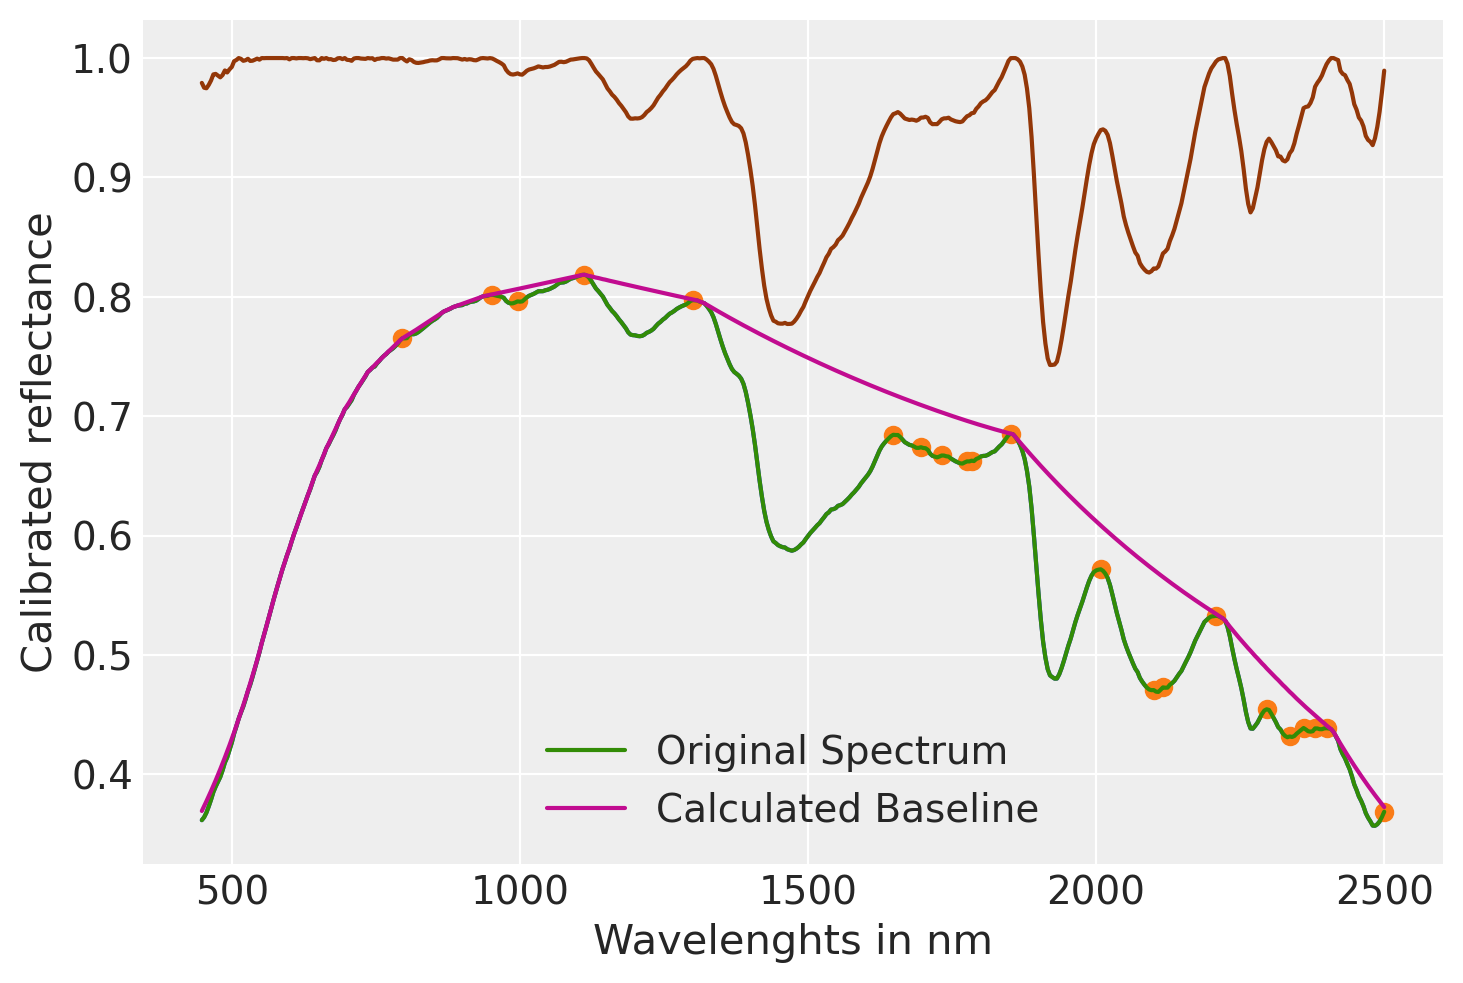

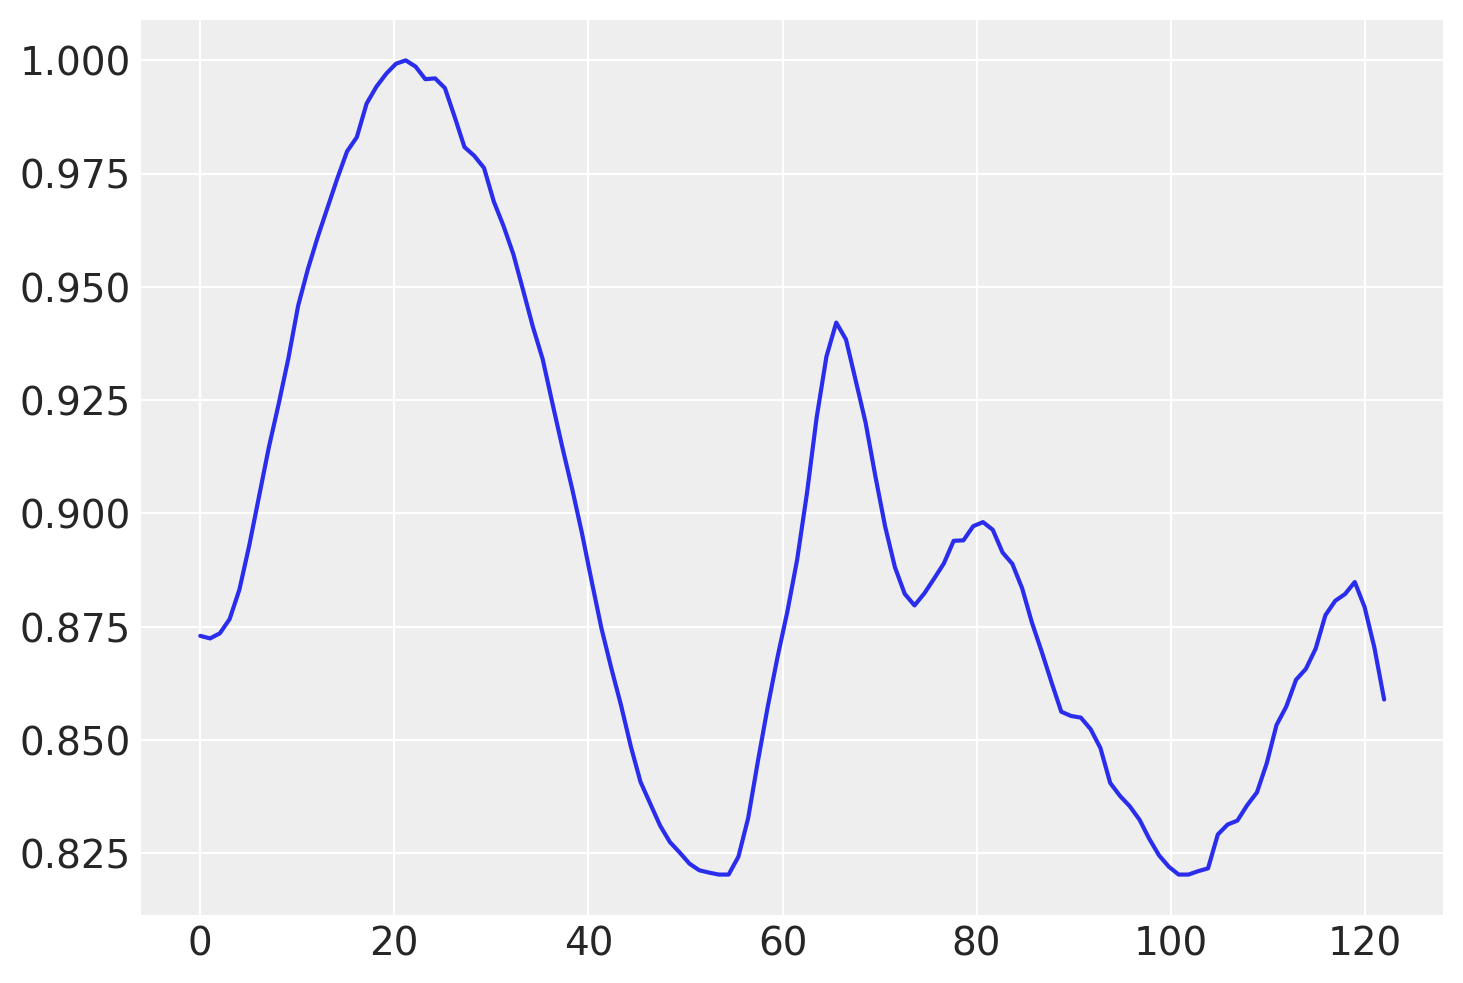

In [49]:
header = envi.read_envi_header('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr')
# img = open_image('spectra/JA0464_18423_0001_20190207135542_00.procProf3d.hdr')
                 # image = 'spectra/JA0464_18423_0001_20190207135542_00.procProf3d.bin')
curr_data = envi.open('spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.hdr', image = 'spectra/JA0464_18423_0001_20190207135542_00.procSpecRefl.bin')

curr_data_array = curr_data.asarray()
print(f"Current data is shaped: {curr_data_array.shape}")

# Let's get the wavelengths in a format we can use
wav_list = [val[0:-2] for val in header['band names']]
wav_array = np.asarray(wav_list).astype(float)

# and the units
wav_unit = header['wavelength units']
n_bands = header['bands']

# Set the pixel we want for now

curr_x = 25
curr_y = 50

curr_pixel = curr_data_array[curr_x, curr_y, :]
plt.plot(wav_array, curr_pixel)
plt.xlabel('Wavelenghts in ' + wav_unit)
plt.ylabel('Calibrated reflectance')

# Get the peaks of the current spectrum
peaks = find_peaks(curr_pixel)[0]
# Append the end of the spectrum
peaks = np.append(peaks, curr_pixel.shape[0]-1)

plt.plot(wav_array[peaks], curr_pixel[peaks], 'o')

# Invert the data 
pix_inverse = 1 / curr_pixel 

baseline_fitter = Baseline(wav_array,
                           check_finite=False)

# Calculate the baseline
baseline_inv = baseline_fitter.snip(pix_inverse,
                             max_half_window=40,
                             decreasing=True,
                             smooth_half_window=0)[0]

# Invert the result
curr_baseline = 1 / baseline_inv         

plt.plot(wav_array, curr_pixel, label='Original Spectrum')
plt.plot(wav_array, curr_baseline, label='Calculated Baseline')
plt.legend()

# open a file, where you stored the pickled data
file = open('baseline_corrected_array.pickle', 'rb')

# dump information to that file
baseline_corrected_data = pickle.load(file)

# close the file
file.close()

curr_spectrum = baseline_corrected_data[25,50,:]

plt.plot(wav_array, curr_spectrum)


curr_start = 390
curr_end = 512
curr_peak = (1 /curr_spectrum[curr_start:curr_end])
# Normalize the current peak
curr_peak = curr_peak / curr_peak.max()
curr_wavs = wav_array[curr_start:curr_end]
plt.figure()
plt.plot(np.linspace(0, curr_peak.shape[0], curr_peak.shape[0]),
          curr_peak)

In [6]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

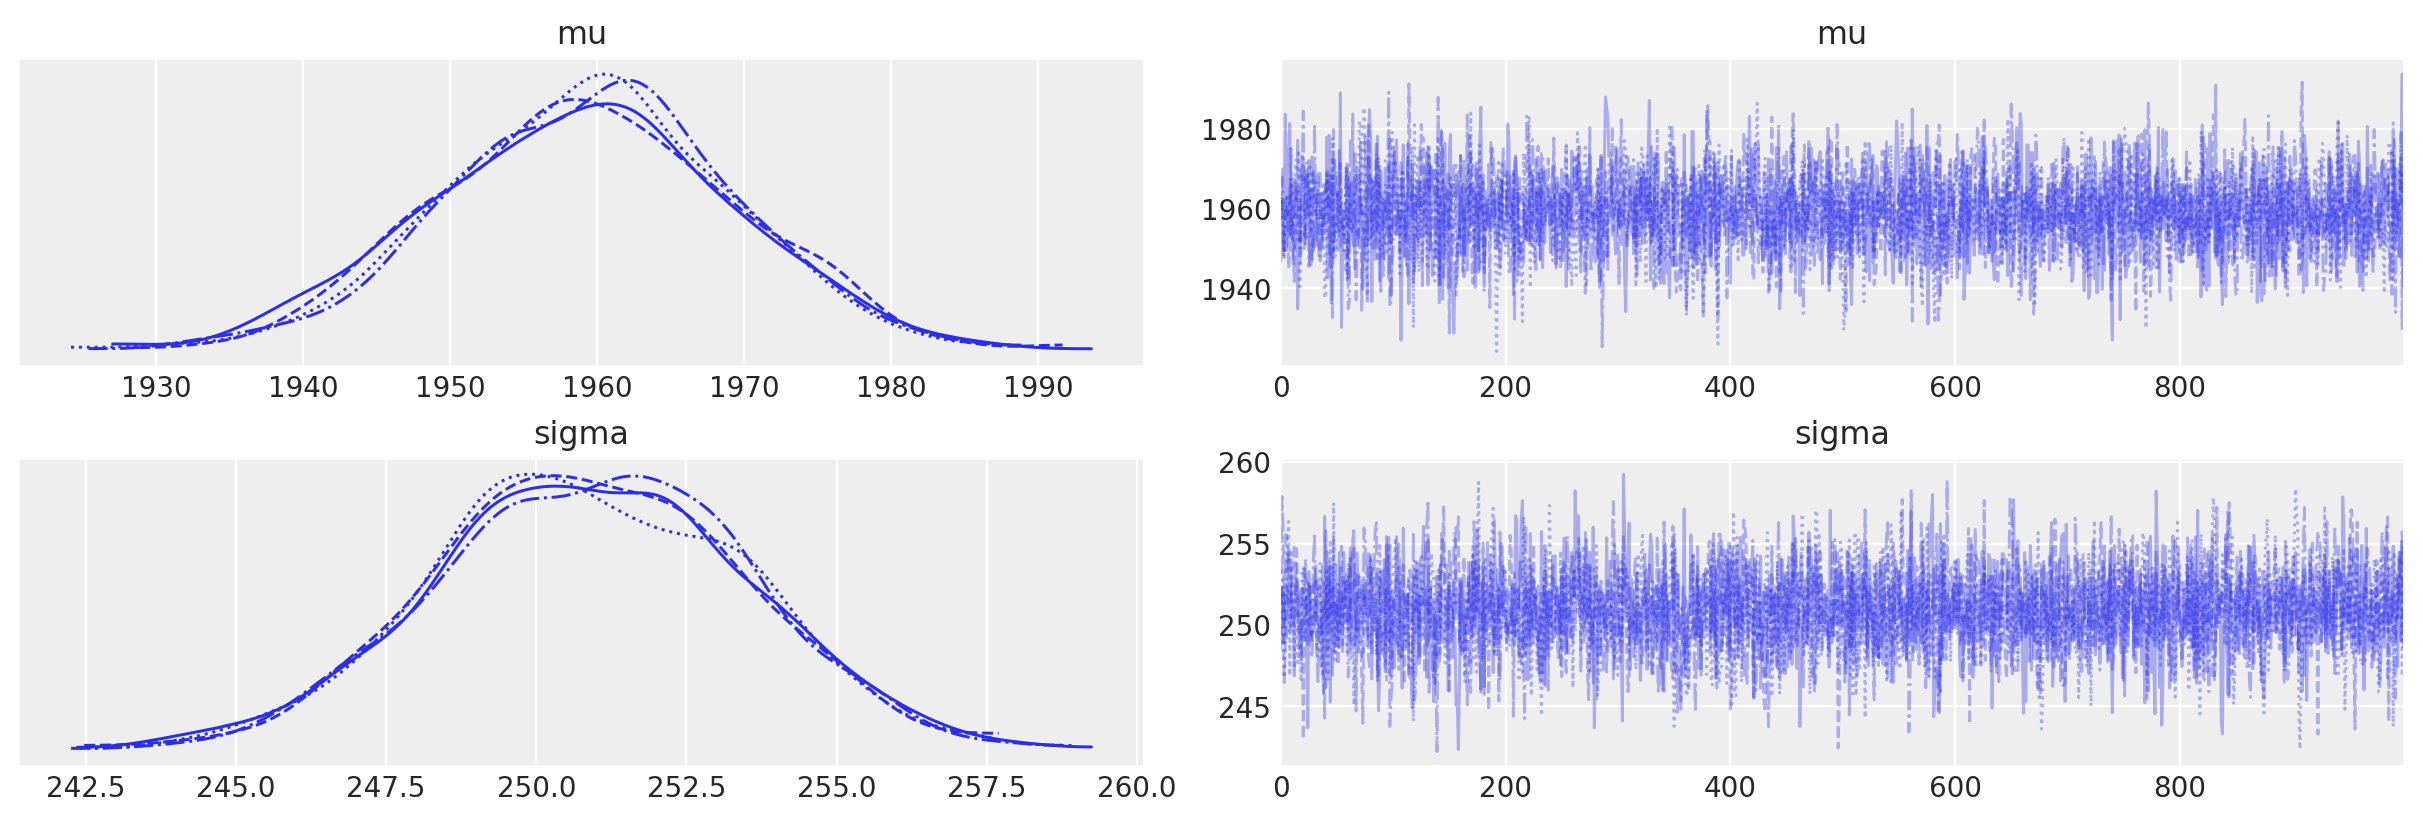

In [34]:
with pm.Model() as model:
    mu = pm.Normal("mu",
                   mu = np.mean(curr_wavs),
                   sigma = 10)
    sigma = pm.HalfNormal("sigma",
                      sigma=5)
                          
    g1 = pm.Normal("g1",
                   mu = mu,
                   sigma = sigma,
                   observed = curr_peak)

with model:
    idata = pm.sample()

az.plot_trace(idata, var_names=["mu", "sigma"]) # , lines=[("μ", {}, [centers]), ("σ", {}, [sds])]);

In [51]:
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=1)
    eta = pm.HalfNormal("eta", sigma=5)

    cov = eta**2 * pm.gp.cov.ExpQuad(1, ell)
    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f",
                 X=curr_wavs[:, None])

    sigma = pm.HalfNormal("sigma",
                          sigma=2.0)
    nu = 1 + pm.Gamma(
        "nu", alpha=2, beta=0.1
    )  # add one because student t is undefined for degrees of freedom less than one
    y_ = pm.StudentT("y", mu=f, lam=1.0 / sigma, nu=nu, observed=curr_peak)

    idata = pm.sample(1000,
                      tune=1000,
                      chains=2,
                      cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [ell, eta, f_rotated_, sigma, nu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2795 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [52]:
# check Rhat, values above 1 may indicate convergence issues
n_nonconverged = int(
    np.sum(az.rhat(idata)[["eta", "ell", "sigma", "f_rotated_"]].to_array() > 1.03).values
)
if n_nonconverged == 0:
    print("No Rhat values above 1.03, \N{check mark}")
else:
    print(f"The MCMC chains for {n_nonconverged} RVs appear not to have converged.")



The MCMC chains for 479 RVs appear not to have converged.


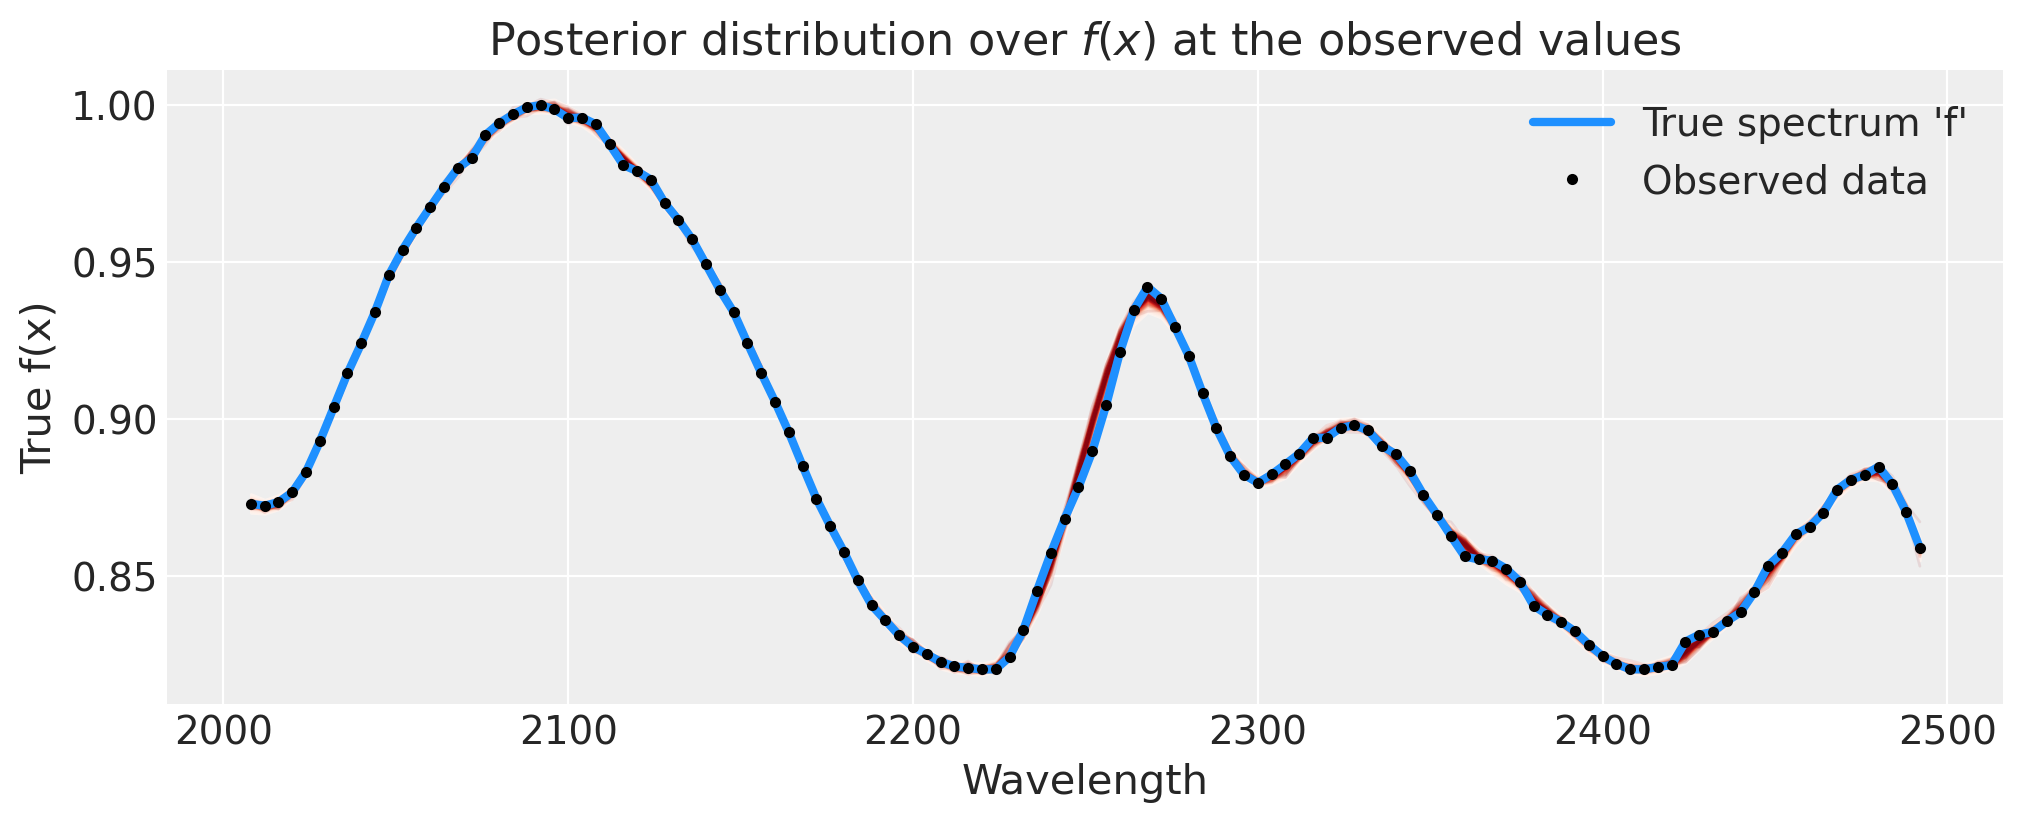

In [54]:
# plot the results
fig = plt.figure(figsize=(10, 4))
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc.gp.util import plot_gp_dist

f_post = az.extract(idata, var_names="f").transpose("sample", ...)
plot_gp_dist(ax, f_post, curr_wavs)

# plot the data and the true latent function
ax.plot(curr_wavs, curr_peak, "dodgerblue", lw=3, label="True spectrum 'f'")
ax.plot(curr_wavs, curr_peak, "ok", ms=3, label="Observed data")

# axis labels and title 
plt.xlabel("Wavelength")
plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values")
plt.legend();

In [17]:
n_peaks = 4
peak0 = [20, 64, 80, 110]

with pm.Model(coords={"cluster": range(n_peaks)}) as model:
    μ = pm.Normal(
        "μ",
        mu=60,
        sigma=5,
        transform=pm.distributions.transforms.univariate_ordered,
        initval=peak0,
        dims="cluster",
    )
    σ = pm.HalfNormal("σ",
                      sigma=50,
                      dims="cluster")
    weights = pm.Dirichlet("w",
                           np.ones(n_peaks),
                           dims="cluster")
    pm.NormalMixture("x",
                     w=weights,
                     mu=μ,
                     sigma=σ,
                     observed=curr_peak)

# pm.model_to_graphviz(model)

In [18]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, w]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'σ'}>, <Axes: title={'center': 'σ'}>]],
      dtype=object)

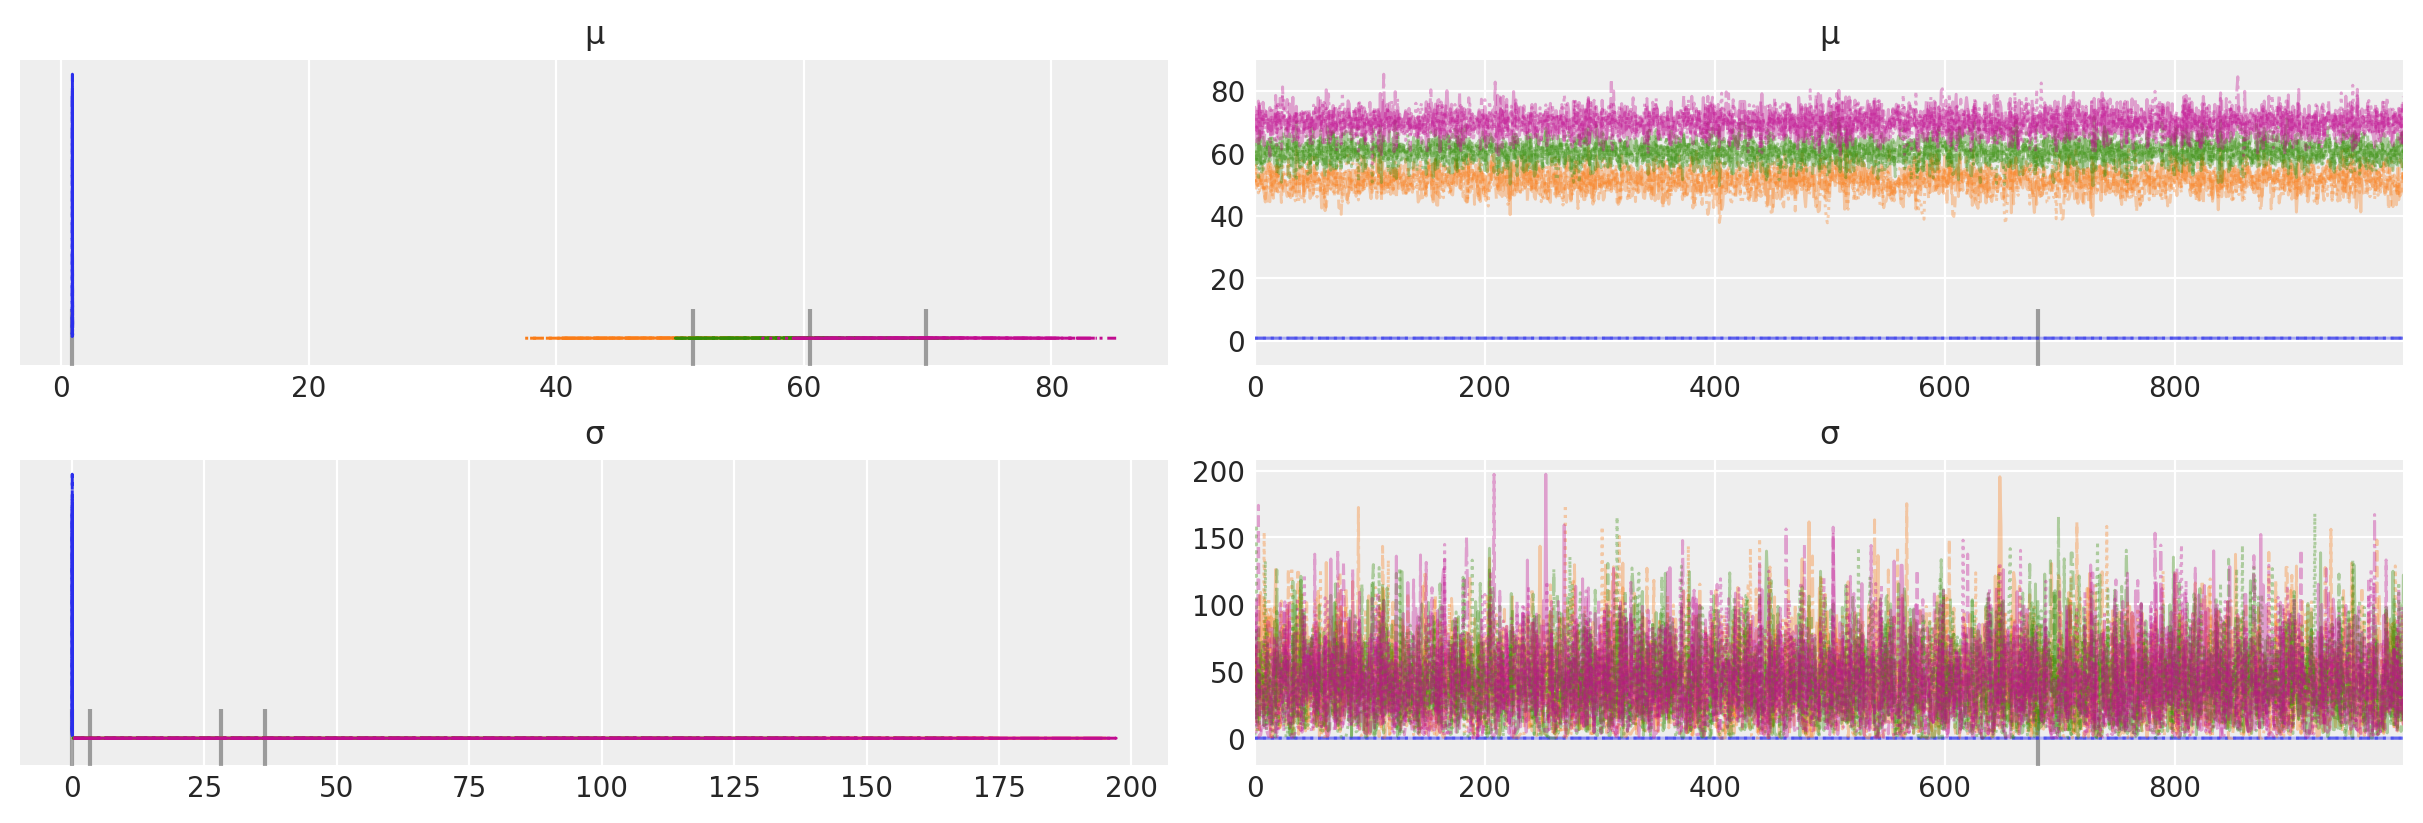

In [19]:
az.plot_trace(idata, var_names=["μ", "σ"]) # , lines=[("μ", {}, [centers]), ("σ", {}, [sds])]);

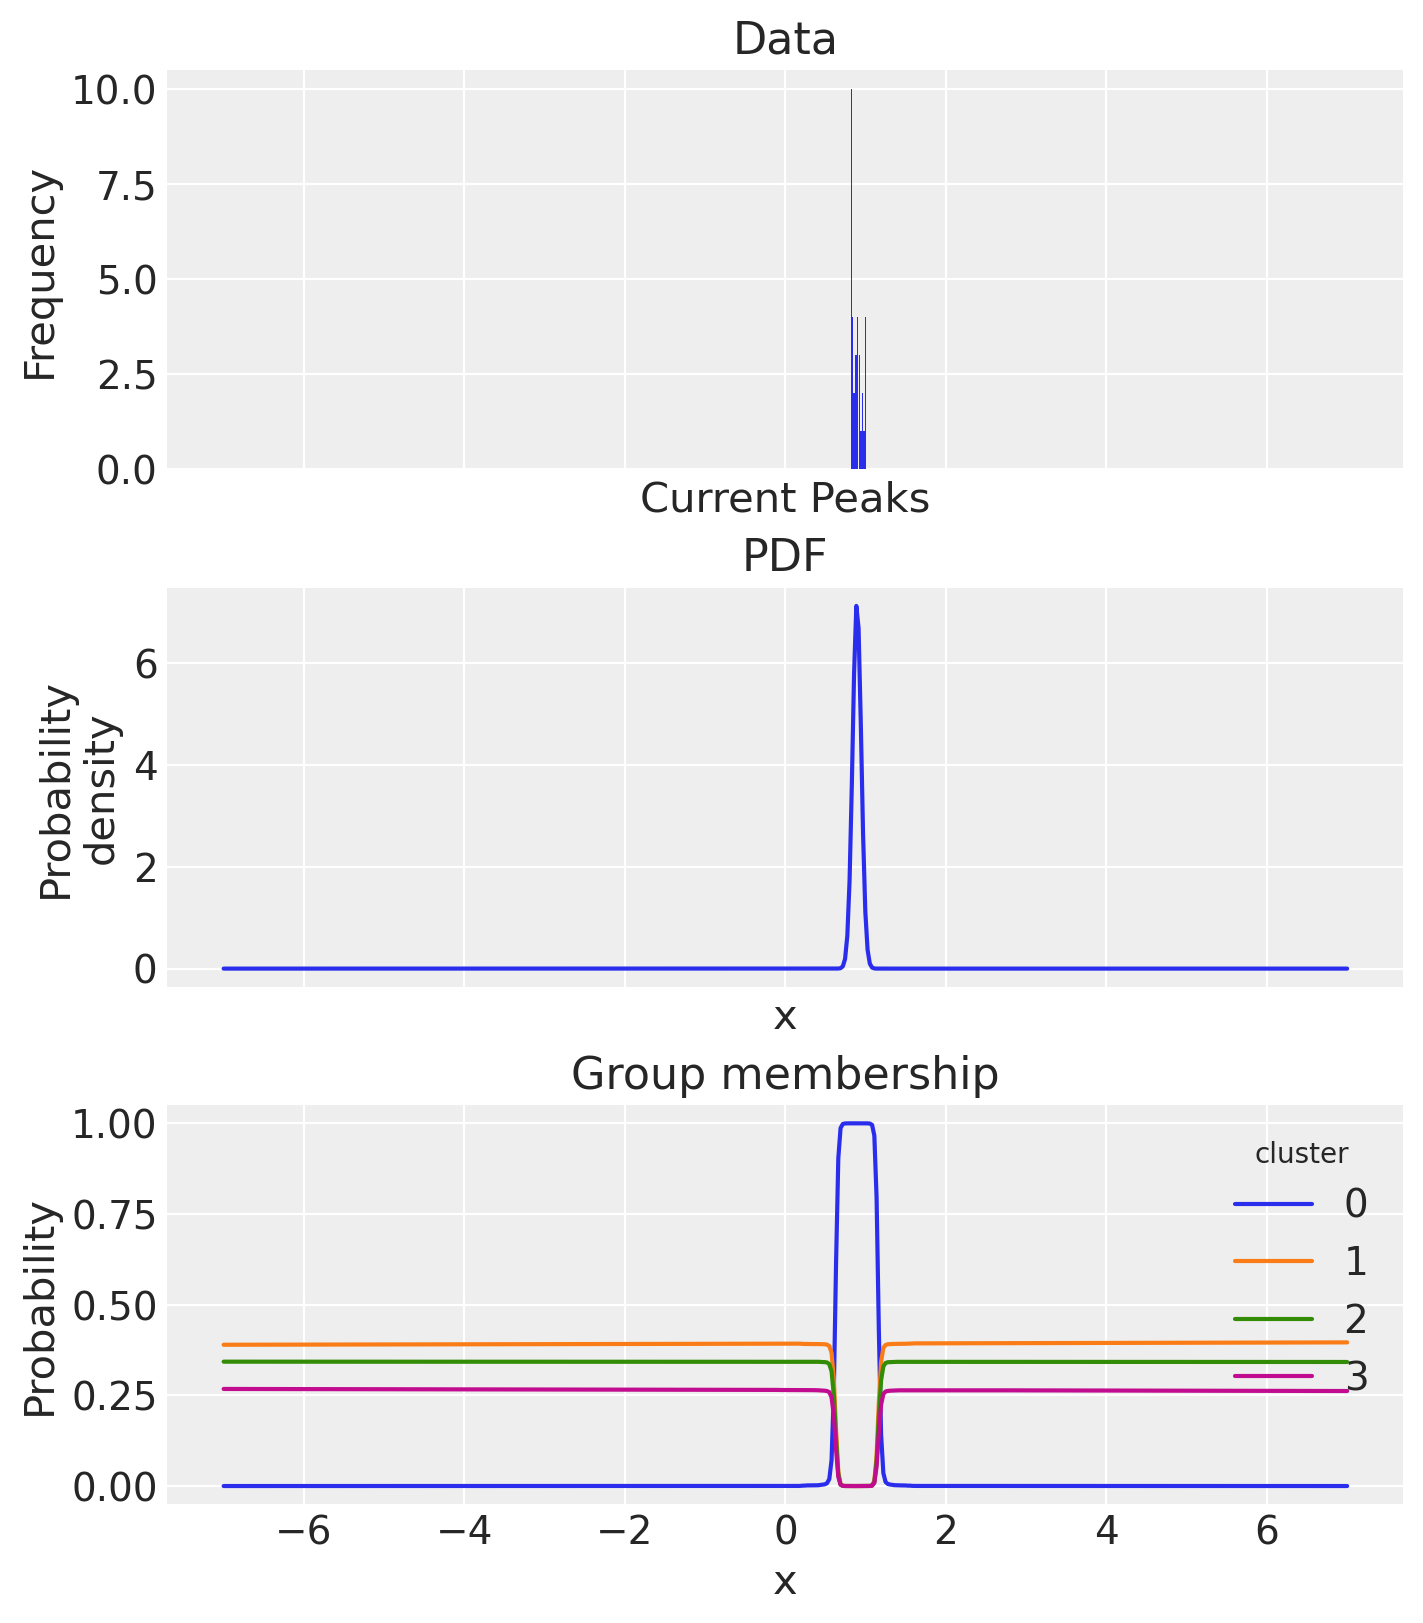

In [21]:
xi = np.linspace(-7, 7, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(curr_peak, 50)
ax[0].set(title="Data", xlabel="Current Peaks", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

In [55]:
# idata.

ModuleNotFoundError: No module named 'boto3'